In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx


[5]
[2]
True


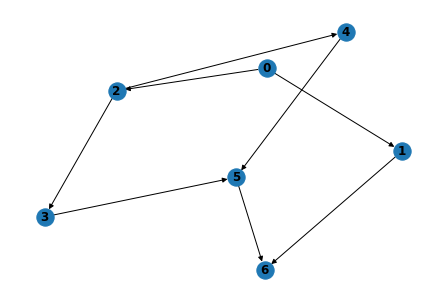

In [2]:
#Degendancy graph init

def initGraph(M):
    N = len(M)
    DG = nx.DiGraph()
    for i in range(0, N):
        for j in range(0, N):
            if (M[i][j] != 0):
                DG.add_edge(i, j)
    return DG

DG_matrix = [
    [0,1,1,0,0,0,0],
    [0,0,0,0,0,0,1],
    [0,0,0,1,1,0,0],
    [0,0,0,0,0,1,0],
    [0,0,0,0,0,1,0],
    [0,0,0,0,0,0,1],
    [0,0,0,0,0,0,0]
]

#DG = nx.DiGraph()
#DG.add_edges_from([(1, 2), (1, 3), (3,4), (3,5), (4,6), (5,6), (6,7), (2,7)]) #1 - start, 7 - end
DG = initGraph(DG_matrix)
print(list(DG.successors(3)))
print(list(DG.predecessors(3)))

print(nx.is_directed_acyclic_graph(DG))

nx.draw(DG, with_labels=True, font_weight='bold')

In [3]:
def getNodeWeight1(DG, i):
    try:
        w = DG.nodes[i]['weight']
    except:
        w = 0
    return w

def normalize_weights_on_graph(DG):
    weights = [getNodeWeight1(DG,i) for i in range(0, len(DG.nodes))]
    new_weights = weights/np.sum(weights)
    print(new_weights)
    for i in range(0, len(DG.nodes)):
        DG.add_node(i, weight=new_weights[i])

[0.47222222 0.05555556 0.22222222 0.08333333 0.08333333 0.05555556
 0.02777778]
[(0, {'weight': 0.4722222222222222}), (1, {'weight': 0.05555555555555555}), (2, {'weight': 0.2222222222222222}), (6, {'weight': 0.027777777777777776}), (3, {'weight': 0.08333333333333333}), (4, {'weight': 0.08333333333333333}), (5, {'weight': 0.05555555555555555})]


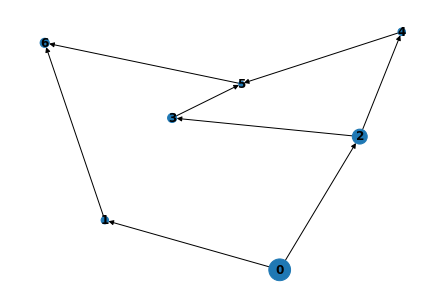

In [4]:
#1 Simple recursive ranking of dependency graph

def resetWeights(DG):
    j = len(DG.nodes)-1
    addWeightToNode(DG, j, 0, reset=True)

def addWeights(DG):
    #j - Last node (finish)
    j = len(DG.nodes)-1
    addWeightToNode(DG, j, 1)
    normalize_weights_on_graph(DG)

    
def addWeightToNode(DG, j, w, reset=False, coef1=1):
    if (reset):
        DG.add_node(j, weight=0)
    else:
        DG.add_node(j, weight=w)
    preds = list(DG.predecessors(j))
    for i in preds:
        try:
            w_i = DG.nodes[i]['weight']
        except:
            #print("Error: weight not defined.")
            w_i = 0
        addWeightToNode(DG, i, w+coef1+w_i, reset)
        
        
resetWeights(DG)        
addWeights(DG)

def showWeightDG(DG, coef=1000):
    print(DG.nodes.data())
    node_sizes = [coef*DG.nodes[i]['weight'] for i in range(0, len(DG.nodes))]
    nx.draw(DG, with_labels=True, font_weight='bold', node_size=node_sizes)
    
showWeightDG(DG)

In [5]:
#2 Simple ranking of dependency graph from total number of successors

def addWeightsSuccessors(DG):
    for i in DG.nodes:
        tot_suc = getTotalSuccessors(DG, i)
       # print tot_suc
        DG.add_node(i, weight=len(tot_suc))
    normalize_weights_on_graph(DG)
    
    
def getTotalSuccessors(DG, i):
    suc_set = set()
    if (len(list(DG.successors(i))) != 0):
        suc_set |= set(list(DG.successors(i)))
        for j in list(DG.successors(i)):
            suc_set.update(getTotalSuccessors(DG, j))
    return suc_set
    

DG_suc = initGraph(DG_matrix)
addWeightsSuccessors(DG_suc)


[0.375  0.0625 0.25   0.125  0.125  0.0625 0.    ]


[0]
[1, 5]


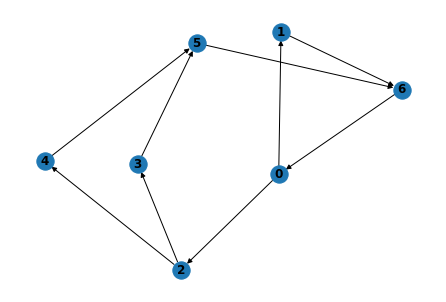

In [6]:
#Cycling graph 1 finish-to-start

def cycleMatrix(M):
    N = len(M)-1
    M_cyc = [row[:] for row in M]
    M_cyc[N][0] = 1
    return M_cyc

DG_cyc_matrix = cycleMatrix(DG_matrix)
DG_cyc = initGraph(DG_cyc_matrix)
print(list(DG_cyc.successors(6)))
print(list(DG_cyc.predecessors(6)))

nx.draw(DG_cyc, with_labels=True, font_weight='bold')

In [8]:
#PageRank for cycled dependency graph

def createPMatrix(M):
    N = len(M)
    P = np.zeros((N, N))
    for i in range(0, N):
        for j in range(0, N):
            if (M[i][j] != 0):
                s_j = getSuccessors(M,i)#count of i successors
                P[j][i] = 1./s_j
    return P #stochastic matrix
                
                
def getSuccessors(M, i):
    N = len(M)
    s = 0
    for j in range(0, N):
        s += M[i][j]
    return s

def getWeightsPageRank(M):
    P = createPMatrix(M)
    N = len(M)
    print(P)
    w, v = LA.eig(P)
    for i in range(0, len(w)):
      #  print w[i]
     #   print v[:,i]
        if (abs(w[i] - 1) < 0.00000001):
            weights = abs(v[:,i])
    return weights
        
            
def addWeightsToGraph(DG, weights):
    N = len(weights)
    for i in range(0, N):
        print(weights[i])
        DG.add_node(i, weight=weights[i])
    normalize_weights_on_graph(DG)
    
    
weights = getWeightsPageRank(DG_cyc_matrix)
print(weights/np.sum(weights))
print(np.sum(weights))
DG_cycPR = initGraph(DG_cyc_matrix)
addWeightsToGraph(DG_cycPR, weights)
DG_cycPR.nodes.data()

[[0.  0.  0.  0.  0.  0.  1. ]
 [0.5 0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  1.  1.  0.  0. ]
 [0.  1.  0.  0.  0.  1.  0. ]]
[0.25   0.125  0.125  0.0625 0.0625 0.125  0.25  ]
2.3590712984783533
0.5897678246195885
0.2948839123097938
0.2948839123097939
0.1474419561548972
0.1474419561548971
0.29488391230979405
0.589767824619589
[0.25   0.125  0.125  0.0625 0.0625 0.125  0.25  ]


NodeDataView({0: {'weight': 0.2500000000000001}, 1: {'weight': 0.12499999999999986}, 2: {'weight': 0.12499999999999989}, 6: {'weight': 0.2500000000000003}, 3: {'weight': 0.06250000000000004}, 4: {'weight': 0.06250000000000001}, 5: {'weight': 0.12499999999999996}})